# Annexe B — Méthodes de calibration

### De quoi parle cette annexe ?

Dans le notebook principal (Sections 5-6), on a construit $U(s)$ (incertitude) et $C(s)$ (confiance). L'agent dit "je suis confiant à 80% pour cette case". Mais **est-ce que c'est vrai ?** Quand il dit 80%, est-ce qu'il a effectivement raison 80% du temps ?

C'est la question de la **calibration** : est-ce que la confiance de l'agent reflète sa vraie performance ?

Cette annexe présente les outils pour mesurer la qualité de cette calibration :
- **ECE** : l'écart moyen entre confiance et performance réelle
- **Reliability diagram** : la visualisation standard de la calibration
- **MI** (Metacognitive Index) : est-ce que l'agent sait *où* il se trompe ?

**Pré-requis :** [00_prism_concepts.ipynb](00_prism_concepts.ipynb) (Sections 4-6)

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.stats import spearmanr
from IPython.display import display
import sys, os

sys.path.insert(0, os.path.abspath('..'))
from prism.pedagogy.toy_grid import ToyGrid

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

---
## 1. Qu'est-ce que la calibration ?

### L'exemple de la météo

Un présentateur météo dit "80% de chance de pluie". Comment savoir s'il est fiable ?

On regarde **tous les jours où il a dit "80%"**. S'il a effectivement plu environ 80% de ces jours-là, il est **bien calibré**. S'il a plu seulement 50% du temps, il est **sur-confiant** — il annonce des probabilités trop élevées.

### Pour PRISM

L'agent dit $C(s) = 0.8$ — "je suis confiant à 80% dans ma prédiction pour la case $s$".

On peut vérifier : parmi toutes les cases où l'agent dit $C \approx 0.8$, sa prédiction SR est-elle correcte ~80% du temps ?

| Situation | Ce que ça veut dire | Conséquence |
|-----------|-------------------|-------------|
| $C(s) \approx accuracy(s)$ | **Bien calibré** — la confiance reflète la réalité | L'agent peut se fier à son propre signal C |
| $C(s) > accuracy(s)$ | **Sur-confiant** — l'agent croit savoir mais se trompe | Dangereux : il n'explore pas assez |
| $C(s) < accuracy(s)$ | **Sous-confiant** — l'agent doute alors qu'il a raison | Moins grave mais gaspille de l'exploration |

### Pourquoi c'est important

Toute la chaîne métacognitive de PRISM (exploration adaptative en Section 7, détection de changement en Section 8, signal IDK en Section 9) repose sur $C(s)$. Si $C$ ne reflète pas la réalité, ces mécanismes prennent de mauvaises décisions.

Le graphe ci-dessous montre 3 exemples synthétiques (bien calibré, sur-confiant, sous-confiant).

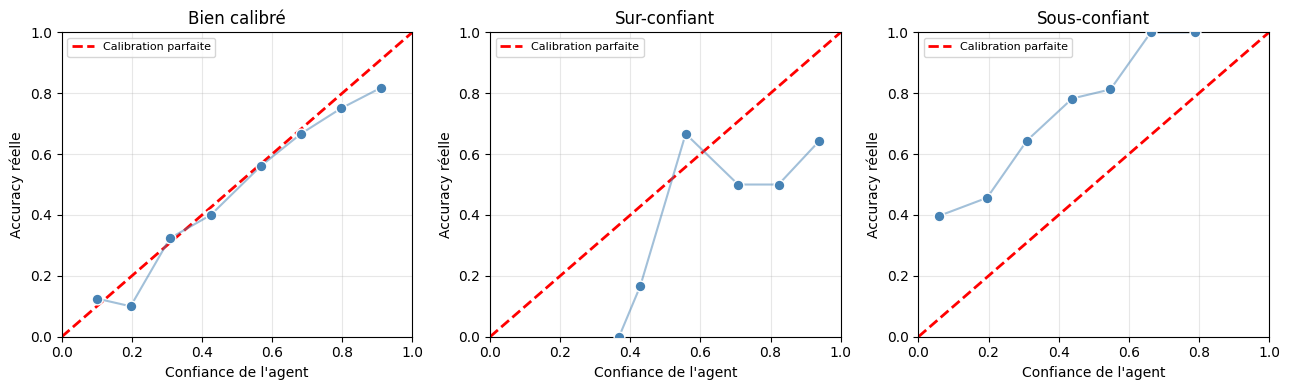

Lecture des 3 graphes :

Chaque graphe montre un 'reliability diagram' :
  Axe horizontal = ce que l'agent DIT (sa confiance)
  Axe vertical   = ce qui est VRAI (son accuracy réelle)
  Diagonale rouge = calibration parfaite (confiance = réalité)
  Chaque point = un groupe de prédictions avec des confiances similaires

Gauche — Bien calibré :
  Les points suivent la diagonale.
  Quand l'agent dit '80% confiant', il a raison ~80% du temps. ✓

Centre — Sur-confiant :
  Les points sont EN DESSOUS de la diagonale.
  L'agent dit '90% confiant' mais n'a raison que ~60% du temps.
  → Il se surestime. Dangereux : il n'explore pas assez.

Droite — Sous-confiant :
  Les points sont AU-DESSUS de la diagonale.
  L'agent dit '20% confiant' mais a raison ~50% du temps.
  → Il se sous-estime. Moins grave, mais gaspille de l'exploration.


In [153]:
# Générer des données synthétiques de calibration
np.random.seed(42)
n = 200

# Cas 1 : bien calibré
conf_good = np.random.beta(2, 2, n)
acc_good = np.array([np.random.binomial(1, c) for c in conf_good])

# Cas 2 : sur-confiant
conf_over = np.random.beta(5, 1, n)
acc_over = np.array([np.random.binomial(1, max(0, c - 0.3)) for c in conf_over])

# Cas 3 : sous-confiant
conf_under = np.random.beta(1, 3, n)
acc_under = np.array([np.random.binomial(1, min(1, c + 0.3)) for c in conf_under])

fig, axes = plt.subplots(1, 3, figsize=(13, 4))
cases = [
    ('Bien calibré', conf_good, acc_good),
    ('Sur-confiant', conf_over, acc_over),
    ('Sous-confiant', conf_under, acc_under),
]

for ax, (name, conf, acc) in zip(axes, cases):
    n_bins = 8
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = []
    bin_accs = []
    for i in range(n_bins):
        mask = (conf >= bin_edges[i]) & (conf < bin_edges[i+1])
        if i == n_bins - 1:
            mask = (conf >= bin_edges[i]) & (conf <= bin_edges[i+1])
        if mask.sum() > 0:
            bin_centers.append(conf[mask].mean())
            bin_accs.append(acc[mask].mean())

    ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Calibration parfaite')
    ax.scatter(bin_centers, bin_accs, s=60, c='steelblue', edgecolors='white', zorder=3)
    ax.plot(bin_centers, bin_accs, '-', color='steelblue', alpha=0.5)
    ax.set_xlabel('Confiance de l\'agent')
    ax.set_ylabel('Accuracy réelle')
    ax.set_title(name)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Lecture des 3 graphes :")
print()
print("Chaque graphe montre un 'reliability diagram' :")
print("  Axe horizontal = ce que l'agent DIT (sa confiance)")
print("  Axe vertical   = ce qui est VRAI (son accuracy réelle)")
print("  Diagonale rouge = calibration parfaite (confiance = réalité)")
print("  Chaque point = un groupe de prédictions avec des confiances similaires")
print()
print("Gauche — Bien calibré :")
print("  Les points suivent la diagonale.")
print("  Quand l'agent dit '80% confiant', il a raison ~80% du temps. ✓")
print()
print("Centre — Sur-confiant :")
print("  Les points sont EN DESSOUS de la diagonale.")
print("  L'agent dit '90% confiant' mais n'a raison que ~60% du temps.")
print("  → Il se surestime. Dangereux : il n'explore pas assez.")
print()
print("Droite — Sous-confiant :")
print("  Les points sont AU-DESSUS de la diagonale.")
print("  L'agent dit '20% confiant' mais a raison ~50% du temps.")
print("  → Il se sous-estime. Moins grave, mais gaspille de l'exploration.")

---
## 2. Expected Calibration Error (ECE)

### Le besoin

On veut un **seul nombre** qui résume "à quel point l'agent est bien calibré". C'est le rôle de l'ECE.

### L'intuition

L'idée est simple :
1. On regroupe les prédictions par niveau de confiance (ex. : toutes les cases où $C \in [0.7, 0.8]$)
2. Pour chaque groupe, on compare la confiance moyenne avec l'accuracy moyenne
3. On fait la moyenne des écarts, pondérée par la taille des groupes

### La formule

$$ECE = \sum_{b=1}^{B} \frac{|B_b|}{N} \cdot |accuracy_b - confidence_b|$$

- $B$ = nombre de groupes (bins)
- $B_b$ = ensemble des prédictions dans le bin $b$
- $|B_b|/N$ = proportion de prédictions dans ce bin (poids)
- $|accuracy_b - confidence_b|$ = écart dans ce bin

### Comment lire le résultat

- **ECE = 0** → calibration parfaite (chaque bin a accuracy = confiance)
- **ECE = 0.05** → bon (5% d'écart en moyenne)
- **ECE = 0.20** → mauvais (20% d'écart)

**Objectif PRISM** : ECE < 0.15

### Le nombre de bins

Le choix de $B$ (nombre de bins) est un compromis :
- **Peu de bins** (3-5) : chaque bin contient beaucoup de données → estimations stables, mais on perd la résolution
- **Beaucoup de bins** (15-20) : résolution fine, mais certains bins peuvent être presque vides → estimations bruitées

In [154]:
def compute_ece(confidences, accuracies, n_bins=10):
    """Calcule l'ECE et les données du reliability diagram."""
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_confs = []
    bin_accs = []
    bin_counts = []

    for i in range(n_bins):
        lo, hi = bin_boundaries[i], bin_boundaries[i + 1]
        mask = (confidences >= lo) & (confidences < hi)
        if i == n_bins - 1:  # dernier bin inclut la borne sup
            mask = (confidences >= lo) & (confidences <= hi)

        count = mask.sum()
        if count > 0:
            bin_confs.append(confidences[mask].mean())
            bin_accs.append(accuracies[mask].mean())
            bin_counts.append(count)
        else:
            bin_confs.append(np.nan)
            bin_accs.append(np.nan)
            bin_counts.append(0)

    bin_confs = np.array(bin_confs)
    bin_accs = np.array(bin_accs)
    bin_counts = np.array(bin_counts)

    # ECE
    valid = bin_counts > 0
    n_total = bin_counts.sum()
    ece = np.sum((bin_counts[valid] / n_total) * np.abs(bin_accs[valid] - bin_confs[valid]))

    return ece, bin_confs, bin_accs, bin_counts

# Test
ece, _, _, _ = compute_ece(conf_good, acc_good)
print(f"ECE (bien calibr\u00e9) : {ece:.4f}")

ece_over, _, _, _ = compute_ece(conf_over, acc_over)
print(f"ECE (sur-confiant) : {ece_over:.4f}")

ECE (bien calibré) : 0.0768
ECE (sur-confiant) : 0.2942


In [155]:
def plot_ece_interactive(n_bins, calibration_type):
    """Visualise l'ECE avec différents nombres de bins."""
    data = {
        'Bien calibré': (conf_good, acc_good),
        'Sur-confiant': (conf_over, acc_over),
        'Sous-confiant': (conf_under, acc_under),
    }
    conf, acc = data[calibration_type]
    ece, bin_confs, bin_accs, bin_counts = compute_ece(conf, acc, n_bins)

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))

    # Reliability diagram (points)
    bin_centers = np.linspace(1/(2*n_bins), 1 - 1/(2*n_bins), n_bins)
    valid = bin_counts > 0

    axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Parfait')
    axes[0].scatter(bin_centers[valid], bin_accs[valid], s=60,
                    c='steelblue', edgecolors='white', zorder=3, label='Accuracy')
    axes[0].plot(bin_centers[valid], bin_accs[valid], '-', color='steelblue', alpha=0.5)
    axes[0].set_xlabel('Confiance (bin moyen)')
    axes[0].set_ylabel('Accuracy (bin moyen)')
    axes[0].set_title(f'Reliability Diagram — ECE = {ece:.4f}')
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Distribution par bin (barres — c'est un comptage)
    width = 1.0 / n_bins
    axes[1].bar(bin_centers, bin_counts, width=width*0.8,
                color='lightcoral', edgecolor='white')
    axes[1].set_xlabel('Confiance (bin)')
    axes[1].set_ylabel('Nombre de prédictions')
    axes[1].set_title(f'Distribution ({n_bins} bins, N={int(bin_counts.sum())})')
    axes[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    # Détail par bin
    delta_header = '|Δ|'
    print(f"{'Bin':>6} {'Conf':>8} {'Acc':>8} {'Count':>8} {delta_header:>8}")
    for i in range(n_bins):
        if bin_counts[i] > 0:
            gap = abs(bin_accs[i] - bin_confs[i])
            print(f"{i+1:>6} {bin_confs[i]:>8.3f} {bin_accs[i]:>8.3f} {int(bin_counts[i]):>8} {gap:>8.3f}")

    print()
    print("Lecture des graphes :")
    print()
    print("Gauche — reliability diagram :")
    print("  Chaque point = un groupe de prédictions avec des confiances similaires")
    print("  Position verticale = accuracy moyenne du groupe")
    print("  Diagonale rouge = calibration parfaite")
    print("  ECE = distance moyenne pondérée entre les points et la diagonale")
    print()
    print("Droite — distribution des données par bin :")
    print("  Montre combien de prédictions tombent dans chaque bin")
    print("  Un bin avec peu de données → point peu fiable")
    print()
    print("À essayer :")
    print("  Bins = 3  → peu de points, estimation stable mais grossière")
    print("  Bins = 20 → beaucoup de points, mais certains bins vides")
    print("  Changer le type de calibration pour voir comment la courbe change")

widgets.interact(
    plot_ece_interactive,
    n_bins=widgets.IntSlider(value=10, min=3, max=20, step=1,
                              description='Bins', continuous_update=False),
    calibration_type=widgets.Dropdown(
        options=['Bien calibré', 'Sur-confiant', 'Sous-confiant'],
        value='Bien calibré', description='Type')
);

interactive(children=(IntSlider(value=10, continuous_update=False, description='Bins', max=20, min=3), Dropdow…

---
## 3. Reliability Diagram : construction pas-à-pas sur la SR

### Qu'est-ce qu'un reliability diagram ?

C'est la visualisation standard de la calibration : on vérifie si la confiance de l'agent correspond à sa vraie performance. On l'a déjà vu avec les données météo (Section 1) et l'ECE (Section 2).

Ici, on va le **construire de zéro** sur notre ToyGrid, en suivant la chaîne complète :

### Les 3 étapes (= les 3 grilles)

| Étape | Ce qu'on calcule | Grille |
|-------|-----------------|--------|
| **1. Erreur réelle** | Pour chaque case : $\|M(s,:) - M^*(s,:)\|$ | Gauche — où M se trompe |
| **2. La réalité** | On fixe un seuil $\tau$ (médiane) : correct si erreur < $\tau$ | Centre — grille vert/rouge |
| **3. Ce que l'agent croit** | La confiance $C(s)$ calculée via $U \to C$ | Droite — grille vert/rouge |

**Comparer centre et droite** : est-ce que les zones vertes sont aux mêmes endroits ? Si oui → l'agent est bien calibré.

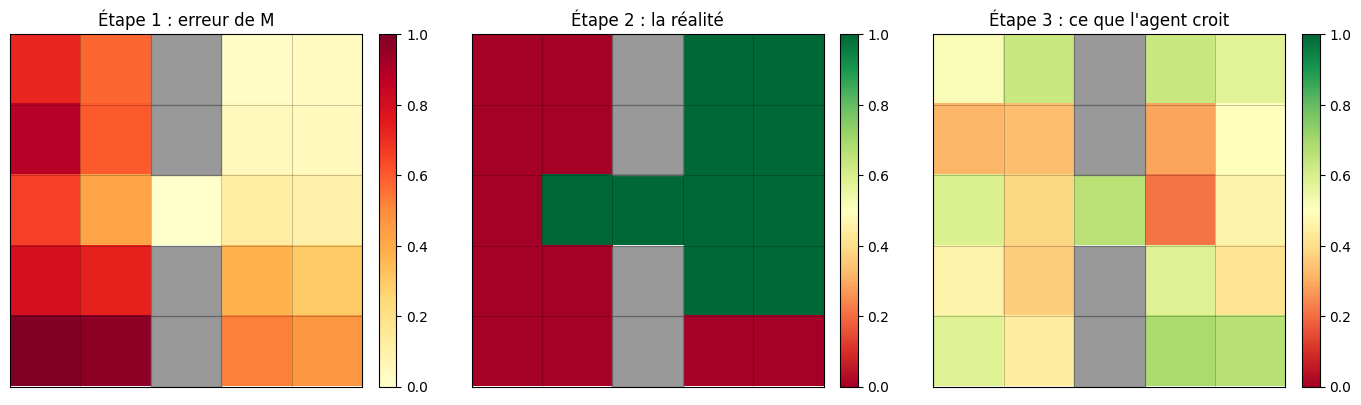

Lecture des 3 grilles :

GAUCHE — erreur réelle de M par case
  Rouge foncé = M est très faux, jaune pâle = M est correct

CENTRE — la réalité (accuracy)
  Seuil τ = médiane des erreurs = 4.272
  Vert = M correct (10 états), rouge = incorrect (11 états)

DROITE — ce que l'agent croit (confiance C)
  Sigmoïde centrée sur médiane(U) = 0.59
  Vert = confiant (U bas), rouge = doute (U haut)

Comparer CENTRE et DROITE :
  Concordance : 10/21 (48%)

  → Calibration imparfaite : les deux grilles ne se ressemblent pas assez

  Même case verte des 2 côtés → l'agent sait ce qu'il sait ✓
  Rouge au centre, verte à droite → SUR-CONFIANT
  Verte au centre, rouge à droite → SOUS-CONFIANT


In [156]:
# Construction pas-à-pas sur les données SR (ToyGrid)
grid = ToyGrid.two_rooms()
gamma = 0.95
M_star = grid.true_sr(gamma)

# Agent partiellement entraîné (1000 steps, comme le notebook principal)
M = np.eye(grid.n_states)
traj = grid.random_walk(1000, seed=42)

# On accumule les erreurs seulement sur les derniers 500 pas
warmup = 500
error_sum = np.zeros(grid.n_states)
error_count = np.zeros(grid.n_states)
recent_norms = []

for t in range(len(traj) - 1):
    s, s_next = traj[t], traj[t+1]
    delta, M = grid.td_update(M, s, s_next, gamma, 0.1)
    if t >= warmup:
        norm = np.linalg.norm(delta)
        error_sum[s] += norm
        error_count[s] += 1
        recent_norms.append(norm)

# --- Étape 1 : erreur réelle par état ---
errors = np.array([np.linalg.norm(M[s] - M_star[s]) for s in range(grid.n_states)])
# Min-max : la plus petite erreur → 0 (jaune), la plus grande → 1 (rouge)
e_min, e_max = errors.min(), errors.max()
errors_norm = (errors - e_min) / (e_max - e_min + 1e-8)

# --- Étape 2 : accuracy binaire (seuil = médiane) ---
tau = np.median(errors)
accuracy = (errors < tau).astype(float)

# --- Étape 3 : U et confiance C ---
p99 = np.percentile(recent_norms, 99) if recent_norms else 1.0
mean_err = np.zeros(grid.n_states)
visited = error_count > 0
mean_err[visited] = error_sum[visited] / error_count[visited]
U = np.where(visited, np.clip(mean_err / max(p99, 1e-8), 0, 1), 0.8)

# On centre la sigmoïde sur la médiane de U pour avoir du contraste
theta_C = np.median(U)
C = 1 / (1 + np.exp(8 * (U - theta_C)))

# === Visualisation : 3 grilles ===
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

grid.plot(values=errors_norm, ax=axes[0], show_goal=False,
          title='Étape 1 : erreur de M', cmap='YlOrRd', vmin=0, vmax=1)

grid.plot(values=accuracy, ax=axes[1], show_goal=False,
          title='Étape 2 : la réalité',
          cmap='RdYlGn', vmin=0, vmax=1)

grid.plot(values=C, ax=axes[2], show_goal=False,
          title='Étape 3 : ce que l\'agent croit',
          cmap='RdYlGn', vmin=0, vmax=1)

plt.tight_layout()
plt.show()

# --- Explications ---
print("Lecture des 3 grilles :")
print()
print("GAUCHE — erreur réelle de M par case")
print("  Rouge foncé = M est très faux, jaune pâle = M est correct")
print()
print("CENTRE — la réalité (accuracy)")
print(f"  Seuil τ = médiane des erreurs = {tau:.3f}")
print(f"  Vert = M correct ({int(accuracy.sum())} états), rouge = incorrect ({int((1 - accuracy).sum())} états)")
print()
print("DROITE — ce que l'agent croit (confiance C)")
print(f"  Sigmoïde centrée sur médiane(U) = {theta_C:.2f}")
print("  Vert = confiant (U bas), rouge = doute (U haut)")
print()
print("Comparer CENTRE et DROITE :")
agree = ((accuracy == 1) & (C >= 0.5)) | ((accuracy == 0) & (C < 0.5))
n_agree = int(agree.sum())
print(f"  Concordance : {n_agree}/{grid.n_states} ({100*n_agree/grid.n_states:.0f}%)")
print()
if n_agree > grid.n_states * 0.7:
    print("  → Bonne calibration : les zones vertes/rouges se ressemblent")
else:
    print("  → Calibration imparfaite : les deux grilles ne se ressemblent pas assez")
print()
print("  Même case verte des 2 côtés → l'agent sait ce qu'il sait ✓")
print("  Rouge au centre, verte à droite → SUR-CONFIANT")
print("  Verte au centre, rouge à droite → SOUS-CONFIANT")

---
## 4. Metacognitive Index (MI)

### La question

L'ECE mesure si la confiance globale est bien calibrée. Mais il y a une question plus fine :

> L'agent sait-il **où** il se trompe ?

Même avec un ECE correct, l'agent pourrait avoir une confiance uniforme partout (ex. $C = 0.5$ sur toutes les cases). Ce serait techniquement calibré, mais inutile — il ne distingue pas les zones bien apprises des zones mal connues.

### L'idée

Le **Metacognitive Index** (MI) mesure si l'incertitude $U(s)$ est **corrélée** avec les vraies erreurs de la SR.

$$MI = \rho_{Spearman}\left(U(s),\; \|M(s,:) - M^*(s,:)\|_2\right)$$

- On prend les 21 états et leurs valeurs de $U$
- On prend les 21 erreurs réelles $\|M(s,:) - M^*(s,:)\|$
- On calcule la corrélation de rang ($\rho_{Spearman}$)

### Pourquoi Spearman (rang) plutôt que Pearson ?

La corrélation de Spearman ne mesure pas si $U$ est proportionnel à l'erreur, mais si **l'ordre est le même** : est-ce que les cases avec le plus gros $U$ sont aussi celles avec la plus grosse erreur ? C'est plus robuste aux valeurs extrêmes.

### Comment lire le résultat

- **MI > 0.5** → l'agent sait bien où il se trompe (objectif PRISM)
- **MI ≈ 0.3** → signal partiel, mais bruité
- **MI ≈ 0** → $U$ ne reflète pas les erreurs réelles — le signal métacognitif est inutile

### Ce que montre le widget

On peut ajouter du **bruit** à $U$ pour voir comment le MI se dégrade. Sans bruit, $U$ reflète parfaitement les erreurs → MI élevé. Avec beaucoup de bruit, $U$ devient aléatoire → MI tombe à 0.

In [157]:
def plot_mi_interactive(noise_level):
    """Visualise l'effet du bruit sur le MI."""
    # Erreurs réelles
    true_errors = errors.copy()

    # U = erreurs + bruit
    noise = np.random.RandomState(42).randn(grid.n_states) * noise_level
    U_noisy = np.clip(true_errors / max(np.percentile(true_errors, 99), 1e-8) + noise, 0, 1)

    # MI
    rho, p_value = spearmanr(U_noisy, true_errors)

    fig, axes = plt.subplots(1, 3, figsize=(13, 4))

    # Scatter U vs erreur
    axes[0].scatter(true_errors, U_noisy, alpha=0.6, s=30, c='steelblue')
    axes[0].set_xlabel('Erreur réelle ||M(s)-M*(s)||')
    axes[0].set_ylabel('U(s) (avec bruit)')
    axes[0].set_title(f'MI = {rho:.3f} (p = {p_value:.4f})')
    axes[0].grid(True, alpha=0.3)

    # Heatmap erreur réelle (min-max pour gradient complet)
    te_min, te_max = true_errors.min(), true_errors.max()
    err_norm = (true_errors - te_min) / (te_max - te_min + 1e-8)
    grid.plot(values=err_norm, ax=axes[1], show_goal=False,
              title='Erreur réelle', cmap='YlOrRd', vmin=0, vmax=1)

    # Heatmap U bruité
    grid.plot(values=U_noisy, ax=axes[2], show_goal=False,
              title=f'U(s) (bruit={noise_level:.1f})', cmap='YlOrRd', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

    print("Lecture des graphes :")
    print()
    print("Gauche — chaque point = un état :")
    print("  Axe X = erreur réelle de M, axe Y = incertitude U estimée par l'agent")
    print("  Si les points suivent une diagonale → U reflète bien les vraies erreurs (MI élevé)")
    print("  Si les points sont dispersés → U est du bruit (MI faible)")
    print()
    print("Centre — erreur réelle sur la grille :")
    print("  Rouge = M est faux ici, jaune pâle = M est correct")
    print()
    print("Droite — U estimé par l'agent :")
    print("  Doit ressembler au centre si l'agent sait ce qu'il ne sait pas")
    print()

    if rho > 0.5:
        verdict = f"MI = {rho:.3f} → Forte corrélation : l'agent sait ce qu'il ne sait pas"
    elif rho > 0:
        verdict = f"MI = {rho:.3f} → Corrélation faible : signal métacognitif partiel"
    else:
        verdict = f"MI = {rho:.3f} → Pas de corrélation : le signal U est du bruit"
    print(verdict)
    print()
    print("À essayer :")
    print("  Bruit = 0   → MI maximal (U = erreur réelle, les deux cartes sont identiques)")
    print("  Bruit = 0.5 → MI diminue (les deux cartes divergent)")
    print("  Bruit = 1.0 → MI ≈ 0 (U est aléatoire, plus aucun lien avec l'erreur)")

widgets.interact(
    plot_mi_interactive,
    noise_level=widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.1,
                                     description='Bruit', continuous_update=False)
);

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Bruit', max=1.0), Output())…

---
## 5. Définition de l'accuracy dans le contexte SR

### Le problème

Pour construire un reliability diagram, on a besoin d'une **accuracy binaire** par état : "la prédiction de l'agent est-elle correcte en $s$, oui ou non ?"

Mais la SR n'est pas un classifieur — il n'y a pas de "bonne réponse" binaire évidente. L'erreur $\|M(s,:) - M^*(s,:)\|$ est un nombre continu. Comment le transformer en "correct / incorrect" ?

### La méthode : seuil à la médiane

1. Calculer l'erreur réelle pour chaque état : $error(s) = \|M(s,:) - M^*(s,:)\|$
2. Prendre la **médiane** de toutes les erreurs comme seuil $\tau$
3. Définir : $accuracy(s) = 1$ si $error(s) < \tau$, sinon $0$

### Pourquoi la médiane ?

- Elle garantit ~50% d'états "corrects" et ~50% "incorrects" → le reliability diagram a assez de données des deux côtés
- Un seuil trop bas (ex. percentile 10) rendrait presque tout "incorrect" → le diagram serait trivial
- Un seuil trop haut (ex. percentile 90) rendrait presque tout "correct" → même problème

Le widget ci-dessous montre comment le choix du percentile affecte le diagram.

### Note importante

Le MI (Section 4) utilise la corrélation de rang, qui ne dépend **pas** du seuil. C'est un avantage : le MI est robuste au choix de $\tau$, contrairement à l'ECE qui en dépend.

In [158]:
def plot_threshold_effect(quantile):
    """Montre l'effet du choix de seuil sur la comparaison réalité vs croyance."""
    tau_q = np.percentile(errors, quantile)
    acc = (errors < tau_q).astype(float)

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # Gauche : distribution des erreurs + seuil
    axes[0].hist(errors, bins=15, color='steelblue', edgecolor='white', alpha=0.7)
    axes[0].axvline(x=tau_q, color='red', linewidth=2, linestyle='--',
                    label=f'seuil = {tau_q:.3f}')
    axes[0].set_xlabel('Erreur ||M(s)-M*(s)||')
    axes[0].set_ylabel("Nombre d'états")
    axes[0].set_title(f'Distribution (percentile {quantile})')
    axes[0].legend(fontsize=8)
    axes[0].grid(True, alpha=0.3)

    # Centre : la réalité (accuracy) — CHANGE avec le slider
    grid.plot(values=acc, ax=axes[1], show_goal=False,
              title=f'La réalité ({acc.mean()*100:.0f}% correct)',
              cmap='RdYlGn', vmin=0, vmax=1)

    # Droite : ce que l'agent croit (C) — NE CHANGE PAS
    grid.plot(values=C, ax=axes[2], show_goal=False,
              title='Ce que l\'agent croit (fixe)',
              cmap='RdYlGn', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

    # Concordance
    agree = ((acc == 1) & (C >= 0.5)) | ((acc == 0) & (C < 0.5))
    n_agree = int(agree.sum())
    n_disagree = grid.n_states - n_agree

    print("Lecture des graphes :")
    print()
    print("GAUCHE — distribution des erreurs de M :")
    print(f"  Ligne rouge = seuil τ (percentile {quantile} = {tau_q:.3f})")
    print("  Les états à gauche du seuil sont 'corrects', ceux à droite 'incorrects'")
    print()
    print("CENTRE — la réalité (change avec le slider) :")
    print(f"  Vert = correct ({int(acc.sum())} états), rouge = incorrect ({int((1-acc).sum())} états)")
    print()
    print("DROITE — ce que l'agent croit (fixe, ne change pas) :")
    print("  Vert = confiant, rouge = pas confiant")
    print()
    print(f"Concordance centre ↔ droite : {n_agree}/{grid.n_states} ({100*n_agree/grid.n_states:.0f}%)")
    print()
    print("À essayer :")
    print("  Bougez le slider : seul le CENTRE change, la DROITE reste fixe.")
    print("  Percentile 50 → ~50/50, bon équilibre pour juger la calibration")
    print("  Percentile 80 → presque tout vert au centre, concordance artificielle")
    print("  Percentile 20 → presque tout rouge au centre, concordance faible")
    print("  → Le MI (Section 4) ne dépend pas de ce choix, c'est son avantage")

widgets.interact(
    plot_threshold_effect,
    quantile=widgets.IntSlider(value=50, min=10, max=90, step=5,
                                description='Percentile τ', continuous_update=False)
);

interactive(children=(IntSlider(value=50, continuous_update=False, description='Percentile τ', max=90, min=10,…

---
## 6. Démo hybride : calibration sur données réelles

Utilise le code PRISM pour calculer ECE et MI sur un vrai agent FourRooms.

**Nécessite** : `pip install -e .` + MiniGrid

In [ ]:
try:
    import minigrid
    import gymnasium as gym
    from prism.agent.prism_agent import PRISMAgent
    from prism.env.state_mapper import StateMapper
    from prism.env.dynamics_wrapper import DynamicsWrapper
    from prism.analysis.calibration import (
        sr_errors, sr_accuracies,
        expected_calibration_error,
        metacognitive_index,
        reliability_diagram_data,
        plot_reliability_diagram
    )

    # Setup
    env = DynamicsWrapper(gym.make("MiniGrid-FourRooms-v0", max_steps=500))
    agent = PRISMAgent(env)

    # Entra\u00eener 200 \u00e9pisodes
    for ep in range(200):
        agent.train_episode()
        if (ep + 1) % 50 == 0:
            print(f"Episode {ep+1}/200")

    # Calculer M*
    T = env.compute_transition_matrix(agent.mapper)
    M_star = np.linalg.inv(np.eye(agent.mapper.n_states) - 0.95 * T)

    # M\u00e9triques
    errors = sr_errors(agent.sr.M, M_star)
    accuracies = sr_accuracies(errors)
    confidences = agent.meta.all_confidences()
    uncertainties = agent.meta.all_uncertainties()

    ece = expected_calibration_error(confidences, accuracies)
    rho, p_val = metacognitive_index(uncertainties, agent.sr.M, M_star)

    print(f"\nECE = {ece:.4f} (cible < 0.15)")
    print(f"MI = {rho:.4f} (p = {p_val:.4f}, cible > 0.5)")

    # Reliability diagram
    fig = plot_reliability_diagram(confidences, accuracies, label='PRISM')
    plt.show()

    env.close()

except ImportError as e:
    print(f"D\u00e9pendance manquante : {e}")
    print("Pour ex\u00e9cuter cette cellule : pip install minigrid gymnasium")
    print("Puis : cd PRISM && pip install -e .")

Episode 50/200
Episode 100/200
Episode 150/200


---
## Résumé

| Métrique | Formule | Interprétation | Cible |
|----------|---------|----------------|-------|
| ECE | $\sum_b \frac{|B_b|}{N} |acc_b - conf_b|$ | Écart moyen confiance/accuracy | < 0.15 |
| MI | $\rho_{Spearman}(U, error)$ | L'agent sait où il se trompe | > 0.5 |
| Accuracy | $\mathbb{1}(\|M-M^*\| < \tau)$ | Prédiction "correcte" binaire | ~50% baseline |

$\leftarrow$ [Retour au notebook principal](00_prism_concepts.ipynb)